# TOPICS
-

# Step 1: Install dependencies and import libraries

In [ ]:
# Install dependencies
!pip install tensorflow
import pandas as pd
import numpy as np
import nltk
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical  # Import to_categorical

# Download punkt tokenizer for text cleaning
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Step 2: Load the dataset and clean the data

In [ ]:
rotc_df = pd.read_csv('/content/ROTC_DATASET.csv')

rotc_feedback_df = pd.read_csv('/content/ROTC_Feedback.csv')

print(rotc_df.columns)
print(rotc_feedback_df.columns)

rotc_df.columns = rotc_feedback_df.columns

combined_df = pd.concat([rotc_df, rotc_feedback_df], ignore_index=True)

combined_csv_path = '/content/ROTC_DATASET_FINAL.csv'
combined_df.to_csv(combined_csv_path, index=False)

combined_df.head()

Index(['Attribute', 'Pattern', 'Response', 'Correlation'], dtype='object')
Index(['Attribute', 'Pattern', 'Response', 'Correlation'], dtype='object')


,Attribute,Pattern,Response,Correlation
0,Leadership,What are the qualities of a good military leader?,"A good leader is decisive, disciplined, and em...","Effective leadership builds trust, enhances mo..."
1,Drills and Commands,What is the purpose of military drills?,"Drills ensure precision, discipline, and effec...",They prepare cadets for real-life scenarios re...
2,Military Values,What are the core values in the military?,"The core values include honor, integrity, loya...",These values guide soldiers in their professio...
3,Military Values,Why are values important in the military?,Values ensure that military personnel uphold e...,"Strong values promote trust, respect, and unit..."
4,Leadership,What are the qualities of a good military leader?,"A good leader is decisive, disciplined, and em...","Effective leadership builds trust, enhances mo..."


In [ ]:
# Load the dataset
df = pd.read_csv('/content/ROTC_DATASET_FINAL.csv')

# Data Cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = nltk.word_tokenize(text)  # Tokenize words
    text = [word for word in text if word.isalnum()]  # Remove non-alphanumeric tokens
    return ' '.join(text)

# Combine 'Pattern' and 'Attribute And Correlation' for input
df['Pattern'] = df['Pattern']

# Clean the 'Pattern' and 'Response' columns
df['Pattern'] = df['Pattern'].apply(clean_text)
df['Response'] = df['Response'].apply(clean_text)
df['Attribute'] = df['Attribute'].apply(clean_text)
df['Correlation'] = df['Correlation'].apply(clean_text)

# Remove fully duplicate rows
df = df.drop_duplicates()

# Handle duplicates in the 'Pattern' column by keeping the first occurrence
df = df.drop_duplicates(subset='Pattern', keep='first')

# Create a new column with formatted responses
df['Formatted_Response'] = df['Response'] + " | Attributes - " + df['Attribute'] + " | Correlation - " + df['Correlation']


# Step 3: Tokenize and pad the input data

In [ ]:
# Tokenize the patterns
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Pattern'])
X = tokenizer.texts_to_sequences(df['Pattern'])

# Padding the sequences to ensure uniform input length
X_pad = pad_sequences(X, padding='post')

# Encode the responses as integers
y = np.array([i for i in range(len(df['Formatted_Response']))])

# Show tokenized input and padded sequences
X_pad[:5], y[:5]



(array([[  1,  11,   2, 152,   6,  10, 246,   7, 102,   0,   0,   0,   0,
           0,   0,   0],
        [  1,   3,   2,  57,   6,   7, 117,   0,   0,   0,   0,   0,   0,
           0,   0,   0],
        [  1,  11,   2, 424, 129,   4,   2,   7,   0,   0,   0,   0,   0,
           0,   0,   0],
        [ 19,  11, 129,  30,   4,   2,   7,   0,   0,   0,   0,   0,   0,
           0,   0,   0],
        [  1,   3,   7,  22,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0]], dtype=int32),
 array([0, 1, 2, 3, 4]))

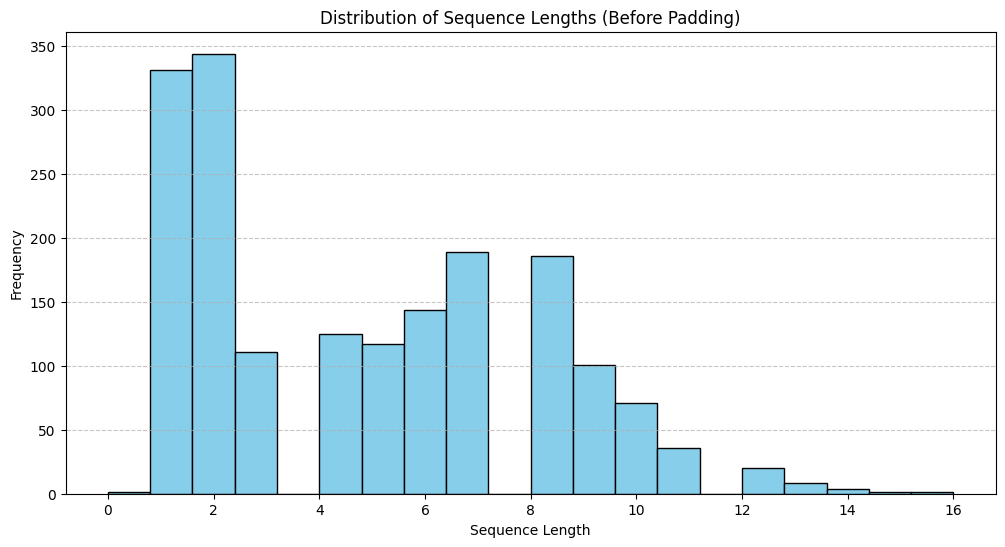

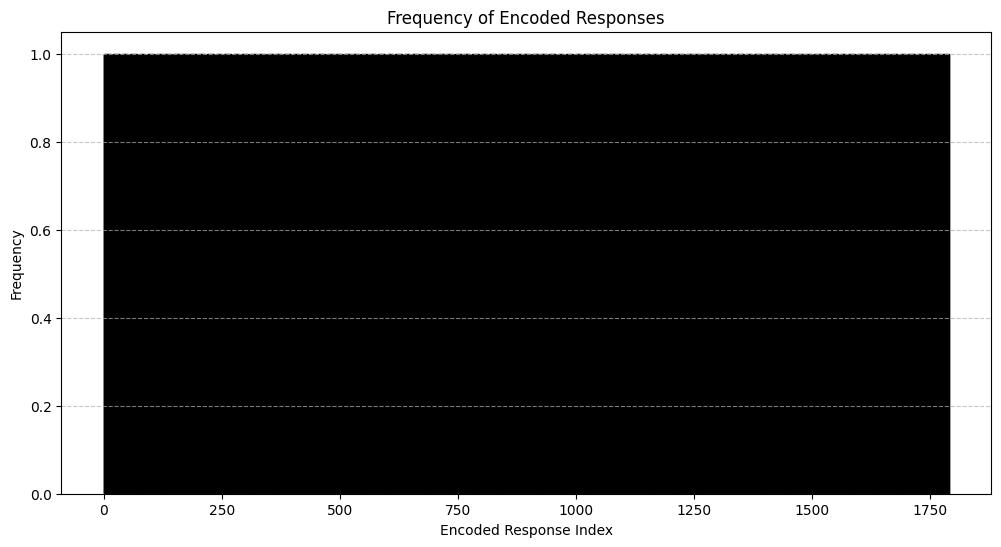

In [ ]:
# Calculate the original lengths of tokenized sequences
sequence_lengths = [len(seq) for seq in X]

# Plot 1: Histogram of sequence lengths
plt.figure(figsize=(12, 6))
plt.hist(sequence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sequence Lengths (Before Padding)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot 2: Frequency of Encoded Responses
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(unique, counts, color='salmon', edgecolor='black')
plt.title('Frequency of Encoded Responses')
plt.xlabel('Encoded Response Index')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Step 4: Split the data into training and validation sets

In [ ]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.2, random_state=42)

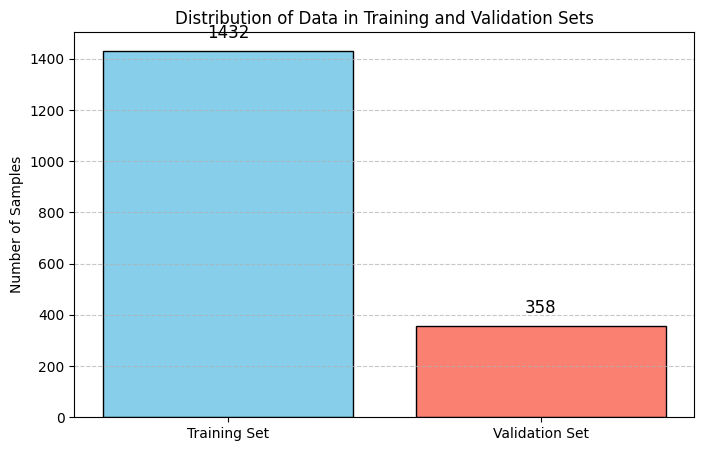

In [ ]:
# Calculate counts for training and validation sets
train_count = len(y_train)
val_count = len(y_val)

# Labels for the graph
labels = ['Training Set', 'Validation Set']
counts = [train_count, val_count]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=['skyblue', 'salmon'], edgecolor='black')
plt.title('Distribution of Data in Training and Validation Sets')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the values on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + 50, str(count), ha='center', fontsize=12)

plt.show()

# Step 5: Build the LSTM model

In [ ]:
# Path to save the model checkpoint
checkpoint_path = '/content/ROTC_chatbot_model_checkpoint.keras'

# Check if a checkpoint exists and load the model if so
if os.path.exists(checkpoint_path):
    print("Checkpoint found! Loading the model...")
    model = load_model(checkpoint_path)  # Load the model from checkpoint
else:
    print("No checkpoint found. Creating a new model.")
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=X_pad.shape[1]))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(df['Formatted_Response']), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

No checkpoint found. Creating a new model.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Step 6: Set up early stopping and model checkpoint callbacks

In [ ]:
# Callbacks for early stopping and checkpoints
checkpoint_callback = ModelCheckpoint(
    checkpoint_path, save_best_only=True, monitor='loss', verbose=1
)

# Custom callback to stop training when accuracy reaches a threshold
class AccuracyThresholdCallback(Callback):
    def __init__(self, accuracy_threshold=0.99):
        super(AccuracyThresholdCallback, self).__init__()
        self.accuracy_threshold = accuracy_threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        if accuracy is not None and accuracy >= self.accuracy_threshold:
            print(f"\nEpoch {epoch + 1}: Accuracy has reached {self.accuracy_threshold}, stopping training.")
            self.model.stop_training = True

# Initialize the accuracy threshold callback
accuracy_threshold_callback = AccuracyThresholdCallback(accuracy_threshold=0.99)

# Step 7: Train the model

In [ ]:
# Calculate class weights to handle imbalanced data
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Train the model with the callbacks
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback, accuracy_threshold_callback],
    class_weight={i: class_weights[i] for i in range(len(class_weights))}
)

Epoch 1/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 7.4925
Epoch 1: loss improved from inf to 7.49718, saving model to /content/ROTC_chatbot_model_checkpoint.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0000e+00 - loss: 7.4928 - val_accuracy: 0.0000e+00 - val_loss: 7.5107
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 7.4835
Epoch 2: loss improved from 7.49718 to 7.48314, saving model to /content/ROTC_chatbot_model_checkpoint.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 7.4835 - val_accuracy: 0.0000e+00 - val_loss: 7.5473
Epoch 3/100
41/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 7.4755
Epoch 3: loss improved from 7.48314 to 7.47498, saving model to /content/ROTC_chatbot_model_checkpoint.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+00 - loss: 7.4755 - val_accuracy: 0.0000e+00 - val_loss: 7.5949
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━

# Step 8: Error analysis on misclassified data

In [ ]:
# Step 8: Error analysis on misclassified data

# Predict classes for validation data
y_pred = np.argmax(model.predict(X_val), axis=1)

# Get the indices of the validation data (use range based on the number of rows in X_val)
val_indices = range(len(X_val))

# Create a DataFrame to compare the true and predicted labels
misclassified_data = pd.DataFrame({
    'True Label': y_val,
    'Predicted Label': y_pred,
    'Text': df['Pattern'].iloc[val_indices].values  # Access the corresponding text based on indices
})

# Find rows where the model's prediction is incorrect
misclassified_data = misclassified_data[misclassified_data['True Label'] != misclassified_data['Predicted Label']]

# Display some of the misclassified data
print("Misclassified Data Sample:")
print(misclassified_data.head(10))  # Display the first 10 misclassified examples


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Misclassified Data Sample:
   True Label  Predicted Label  \
0         942              776   
1        1418              214   
2         486              338   
3         427              739   
4        1303             1314   
5         755              792   
6        1541              580   
7         841             1365   
8        1782              720   
9         462             1099   

                                                Text  
0   what are the qualities of a good military leader  
1             what is the purpose of military drills  
2           what are the core values in the military  
3           why are values important in the military  
4                        what is military discipline  
5               why is military discipline important  
6      why should rotc cadets learn military customs  
7             how does leadership impact rotc cadets  
8           what are military customs and traditions  
9  how of

In [ ]:
# Count the misclassifications for each class
misclassified_count = misclassified_data.groupby(['True Label', 'Predicted Label']).size().reset_index(name='Count')

# You can also group by just 'True Label' if you want to see which classes were mostly misclassified
misclassified_count_per_class = misclassified_data.groupby('True Label').size().reset_index(name='Misclassified Count')


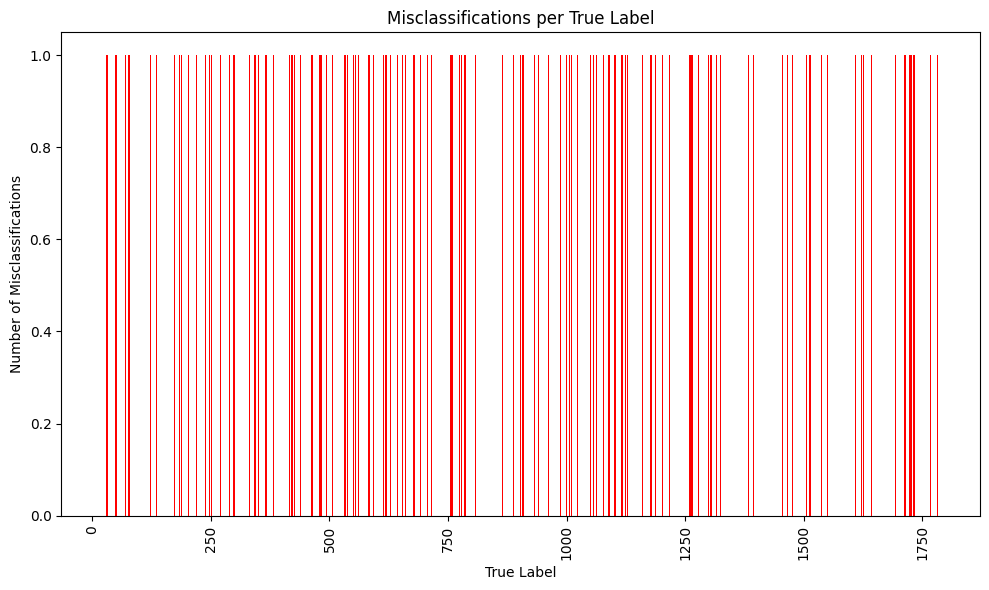

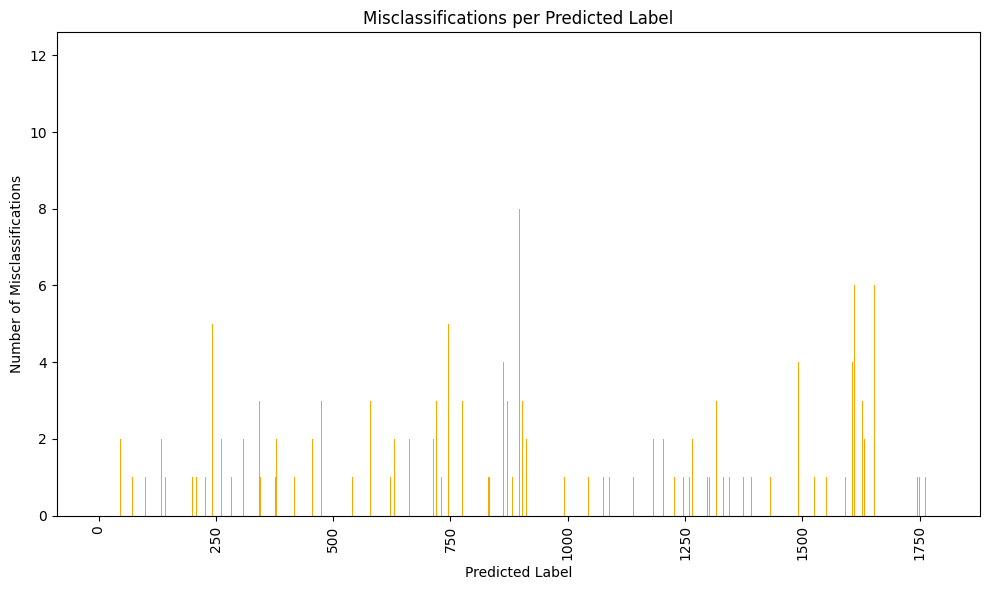

In [ ]:
# Plotting misclassifications per true label
plt.figure(figsize=(10, 6))
plt.bar(misclassified_count_per_class['True Label'], misclassified_count_per_class['Misclassified Count'], color='red')
plt.title('Misclassifications per True Label')
plt.xlabel('True Label')
plt.ylabel('Number of Misclassifications')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Optionally, you can also plot misclassifications per predicted label
misclassified_count_per_pred = misclassified_data.groupby('Predicted Label').size().reset_index(name='Misclassified Count')

plt.figure(figsize=(10, 6))
plt.bar(misclassified_count_per_pred['Predicted Label'], misclassified_count_per_pred['Misclassified Count'], color='orange')
plt.title('Misclassifications per Predicted Label')
plt.xlabel('Predicted Label')
plt.ylabel('Number of Misclassifications')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Step 9: Adjust model weights and retrain

In [ ]:
# Calculate class weights to handle class imbalance
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# One-hot encode the target variables
y_train_encoded = to_categorical(y_train, num_classes=len(df['Formatted_Response']))  # One-hot encode y_train
y_val_encoded = to_categorical(y_val, num_classes=len(df['Formatted_Response']))  # One-hot encode y_val

# Modify the model compilation to include Precision and Recall
model.compile(
    loss='categorical_crossentropy',  # Change loss to categorical_crossentropy
    optimizer='adam',
    metrics=['accuracy', Precision(), Recall()]  # Add Precision and Recall metrics
)

# Retrain the model with class weights and one-hot encoded targets
history = model.fit(
    X_train, y_train_encoded,  # Use one-hot encoded y_train
    validation_data=(X_val, y_val_encoded),  # Use one-hot encoded y_val
    epochs=100, batch_size=32, verbose=1,
    callbacks=[checkpoint_callback, accuracy_threshold_callback],
    class_weight=class_weights_dict
)


Epoch 1/300
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7604 - loss: 0.7368 - precision_6: 0.8345 - recall_6: 0.6629
Epoch 1: loss did not improve from 0.17582
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7585 - loss: 0.7402 - precision_6: 0.8333 - recall_6: 0.6609 - val_accuracy: 0.0000e+00 - val_loss: 60.3857 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9275 - loss: 0.3192 - precision_6: 0.9759 - recall_6: 0.8571
Epoch 2: loss did not improve from 0.17582
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9273 - loss: 0.3196 - precision_6: 0.9759 - recall_6: 0.8570 - val_accuracy: 0.0000e+00 - val_loss: 61.0789 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/300
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9541 - loss: 0.2548 - precision_6: 0.9834 - recall_6: 0.8870
Epoch 3: loss did not improve from 0.17582
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 

In [ ]:
# Save the retrained model
model.save('/content/ROTC_chatbot_model.keras')

print("Model saved as 'ROTC_chatbot_model.keras'")

Model saved as 'ROTC_chatbot_model.keras'


# Step 10: Function to predict responses


In [ ]:
# Function to predict responses
def get_response(text):
    cleaned_text = clean_text(text)  # Ensure the text is preprocessed
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=X_pad.shape[1], padding='post')
    pred = model.predict(padded)
    response_idx = np.argmax(pred)
    # Extract formatted response (includes Attribute and Correlation)
    formatted_response = df['Formatted_Response'].iloc[response_idx]
    # Split into main response, attributes, and correlation
    main_response = formatted_response.split(" | ")[0]  # Main response (before 'Attributes')
    attributes = formatted_response.split(" | ")[1].replace("Attributes - ", "")  # Extract attributes
    correlation = formatted_response.split(" | ")[2].replace("Correlation - ", "")  # Extract correlation
    return f"Chatbot: {main_response}\nAttributes: {attributes}\nCorrelation: {correlation}"



# Step 11: Chatbot loop for testing

In [ ]:
"""# Step 11: Chatbot loop for testing"""

# Chatbot Loop
print("HELLO! ASK ME ABOUT ROTC KNOWLEDGE. TYPE 'EXIT' TO END THE CONVERSATION.")
while True:
    user_input = input("YOU: ")
    if user_input.lower() == 'exit':
        print("GOODBYE!")
        break
    response = get_response(user_input)
    print(response.upper())  # Convert response to uppercase

HELLO! ASK ME ABOUT ROTC KNOWLEDGE. TYPE 'EXIT' TO END THE CONVERSATION.
YOU: m16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
CHATBOT: CONSISTENT APPEARANCE AND ACTIONS AMONG PERSONNEL
ATTRIBUTES: UNIFORMITY
CORRELATION: UNIFORMITY ENSURES SYNCHRONIZATION AND DISCIPLINE
YOU: ROTC
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
CHATBOT: ROTC RESERVE OFFICERS TRAINING CORPS IS A PROGRAM DESIGNED TO TRAIN STUDENTS FOR LEADERSHIP ROLES IN THE MILITARY
ATTRIBUTES: ROTC
CORRELATION: BASIC INTRODUCTION TO ROTC
YOU: What is ROTC
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
CHATBOT: ROTC RESERVE OFFICERS TRAINING CORPS IS A PROGRAM DESIGNED TO TRAIN STUDENTS FOR LEADERSHIP ROLES IN THE MILITARY
ATTRIBUTES: ROTC
CORRELATION: BASIC INTRODUCTION TO ROTC
YOU: M16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
CHATBOT: CONSISTENT APPEARANCE AND ACTIONS AMONG PERSONNEL
ATTRIBUTES: UNIFORMITY
CORRELATION: UNIFORMITY ENSURES SYNCHRONIZATION AND DISCIPLINE
YOU: Shotgun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
CHATBOT: A SHOTGUN FIRES MU

# Step 12: Feedback CSV Collection

In [ ]:
import csv

# Ensure the feedback file exists and has the correct columns
feedback_file = 'ROTC_Feedback.csv'
if not os.path.exists(feedback_file):
    with open(feedback_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Attribute', 'Pattern', 'Response', 'Correlation'])  # Column headers

# Chatbot Loop
print("HELLO! ASK ME ABOUT ROTC KNOWLEDGE. TYPE 'EXIT' TO END THE CONVERSATION.")
while True:
    user_input = input("YOU: ")
    if user_input.lower() == 'exit':
        print("GOODBYE!")
        break

    # Get chatbot response
    response = get_response(user_input)
    print(response.upper())  # Convert response to uppercase

    # Prompt user for feedback
    feedback = input("IS THIS RESPONSE CORRECT? (YES/NO): ").strip().lower()

    if feedback == 'no':
        print("PLEASE HELP ME IMPROVE!")
        corrected_pattern = input("ENTER THE CORRECT PATTERN OR QUESTION: ").strip()
        corrected_response = input("ENTER THE CORRECT RESPONSE: ").strip()
        corrected_attribute = input("ENTER THE RELATED ATTRIBUTE: ").strip()
        corrected_correlation = input("ENTER THE CORRELATION: ").strip()

        # Save the corrected feedback to the feedback dataset
        with open(feedback_file, mode='a', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow([corrected_attribute, corrected_pattern, corrected_response, corrected_correlation])
        print("THANK YOU FOR YOUR FEEDBACK! IT HAS BEEN RECORDED.")

    elif feedback == 'yes':
        print("GLAD I COULD HELP!")

print("CHATBOT SESSION ENDED.")



HELLO! ASK ME ABOUT ROTC KNOWLEDGE. TYPE 'EXIT' TO END THE CONVERSATION.
YOU: Leadership
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
CHATBOT: LEADERSHIP IS ESSENTIAL FOR GUIDING TEAMS AND MAKING DECISIONS
ATTRIBUTES: LEADERSHIP
CORRELATION: LEADERSHIP ENSURES THE SUCCESS OF THE UNIT AND MISSION
IS THIS RESPONSE CORRECT? (YES/NO): YES
GLAD I COULD HELP!
YOU: Leadship
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
CHATBOT: IS VITAL IN ROTC FOR MAINTAINING FOCUS AND HANDLING STRESS
ATTRIBUTES: 
CORRELATION: HELPS MANAGE EMOTIONS AND STAY FOCUSED
IS THIS RESPONSE CORRECT? (YES/NO): NO
PLEASE HELP ME IMPROVE!
ENTER THE CORRECT PATTERN OR QUESTION: Leadship
ENTER THE CORRECT RESPONSE: EADERSHIP IS ESSENTIAL FOR GUIDING TEAMS AND MAKING DECISIONS
ENTER THE RELATED ATTRIBUTE: LEADERSHIP
ENTER THE CORRELATION: LEADERSHIP ENSURES THE SUCCESS OF THE UNIT AND MISSION
THANK YOU FOR YOUR FEEDBACK! IT HAS BEEN RECORDED.
YOU: exit
GOODBYE!
CHATBOT SESSION ENDED.
